# TensorFlow Tutorial #03
# Convolutional Neural Network
# rewrite the tutorial to conform to NN skeleton
the original code is written by 
by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

## Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

## inference 
Following are the helper function for building graph

In [46]:
def variable_summaries(var, name):
    """Attach a lot of summaries to a Tensor."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.scalar_summary('mean/' + name, mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.scalar_summary('stddev/' + name, stddev)
        tf.scalar_summary('max/' + name, tf.reduce_max(var))
        tf.scalar_summary('min/' + name, tf.reduce_min(var))
        tf.histogram_summary(name, var)

#---------------------------------------------
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,
                   layer_name):        # Number of filters.
                   

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    # Adding a name scope ensures logical grouping of the layers in the graph.
    with tf.name_scope(layer_name):
        # This Variable will hold the state of the weights for the layer
        with tf.name_scope('weights'):
            shape = [filter_size, filter_size, num_input_channels, num_filters]
            # Create new weights aka. filters with the given shape.
            weights = new_weights(shape=shape)
            variable_summaries(weights, layer_name + '/weights')
        
        with tf.name_scope('biases'):
            # Create new biases, one for each filter.
            biases = new_biases(length=num_filters)
            variable_summaries(biases, layer_name + '/biases')
        
        with tf.name_scope('conv'):
            # Create the TensorFlow operation for convolution.
            preactivate = tf.nn.conv2d(input=input,
                                filter=weights,
                                 strides=[1, 1, 1, 1],
                                 padding='SAME')+biases
            tf.histogram_summary(layer_name + '/pre_activations', preactivate)

   
    
    
    
    # This is 2x2 max-pooling, which means that we
    # consider 2x2 windows and select the largest value
    # in each window. Then we move 2 pixels to the next window.
    max_pool = tf.nn.max_pool(value=preactivate,
                            ksize=[1, 2, 2, 1], # corresponding to  batch, height, width, channel
                            strides=[1, 2, 2, 1],
                            padding='SAME')
    # Rectified Linear Unit (ReLU).
    activation = tf.nn.relu(max_pool)
    
    tf.histogram_summary(layer_name + '/activations', activation)

    return activation, weights


def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 layer_name,
                 useRelu = True): 

    # Create new weights and biases.
    with tf.name_scope(layer_name):
        with tf.name_scope('weights'):
            weights = new_weights(shape=[num_inputs, num_outputs])
            variable_summaries(weights, layer_name + '/weights')
        
        with tf.name_scope('biases'):
            biases = new_biases(length=num_outputs)
            variable_summaries(biases, layer_name + '/biases')

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    with tf.name_scope('Wx_plus_b'):
        preactivate = tf.matmul(input, weights) + biases
        tf.histogram_summary(layer_name + '/pre_activations', preactivate)
    

    if useRelu:
        activations = tf.nn.relu(preactivate)
    else:
        activations = preactivate
    
    tf.histogram_summary(layer_name + '/activations', activations)

    return activations

The following chart shows roughly how the data flows in the Convolutional Neural Network that is implemented below.

This is the also the inference graph


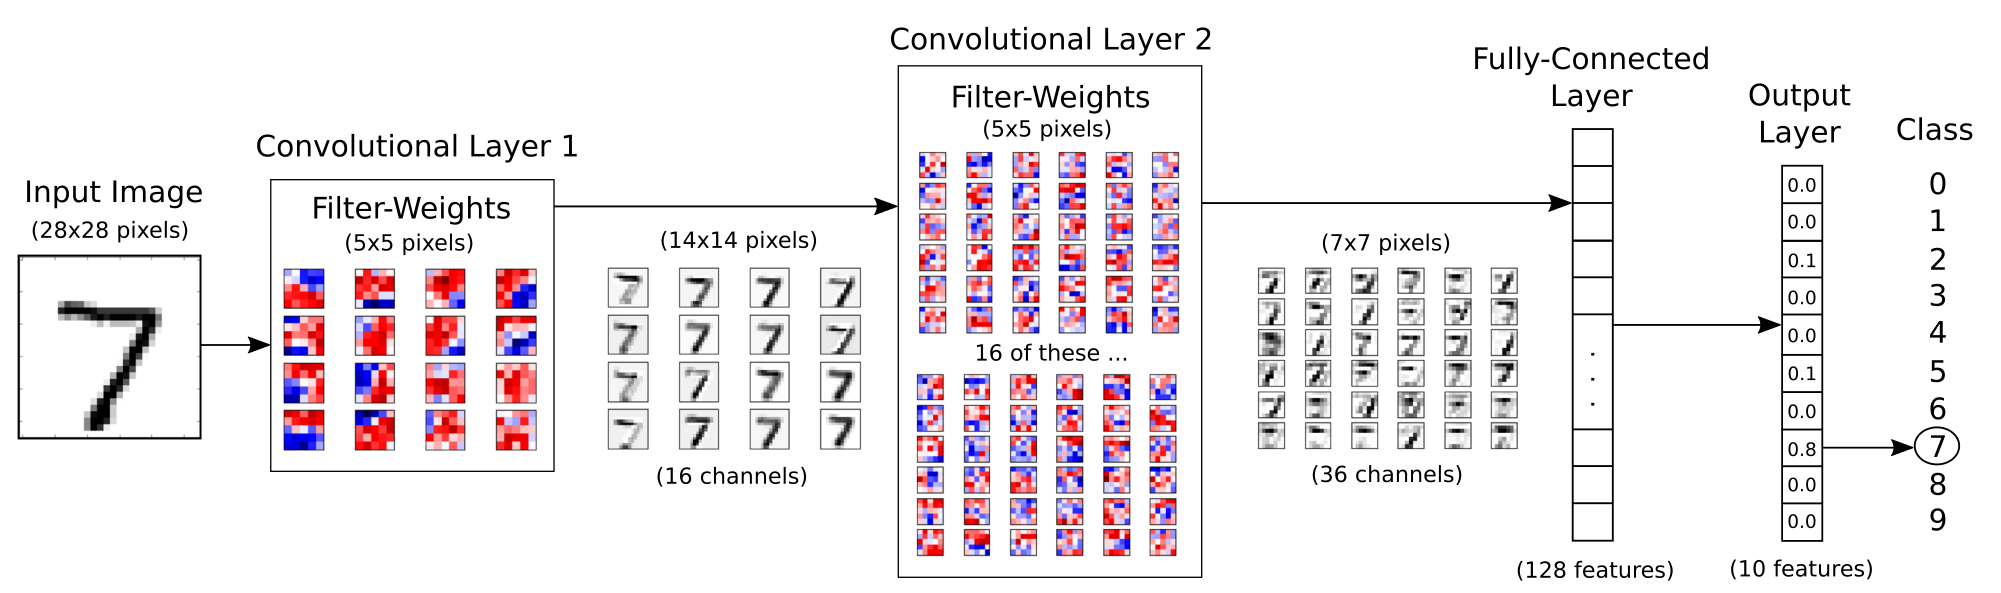

In [37]:
from IPython.display import Image
print 'This is the also the inference graph'
Image('images/02_network_flowchart.png')

This was developed using Python 3.5.2 (Anaconda) and TensorFlow version:

### Configuration of Neural Network

The configuration of the Convolutional Neural Network is defined here for convenience, so you can easily find and change these numbers and re-run the Notebook.

In [47]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

In [48]:
def inference(x_image):
    
    layer_conv1, weights_conv1 = new_conv_layer(input=x_image,
                                                num_input_channels=num_channels,
                                                filter_size=filter_size1,
                                                num_filters=num_filters1,
                                                layer_name='conv1')
    
    layer_conv2, weights_conv2 = new_conv_layer(input=layer_conv1,
                                                num_input_channels=num_filters1,
                                                filter_size=filter_size2,
                                                num_filters=num_filters2,
                                               layer_name='conv2')
                  
    
    # flatten layer before FC NN    
    layer_flat, num_features = flatten_layer(layer_conv2)

    # fully connected NN (FC NN)
    layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         layer_name='FCNN1')

    before_logits = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         layer_name='FCNN2',
                         useRelu=False)
    
    return before_logits

In [62]:
def loss(logits,labels):
    xentropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, 
                                                        labels=labels, name=None)
    return tf.reduce_mean(xentropy)
    
def training(loss,learning_rate):
    
    # Add a scalar summary for the snapshot loss.
    tf.scalar_summary(loss.op.name, loss)
    #Create the gradient descent optimizer with the given learning rate.
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss)
    return train_op




In [57]:
def eval(logits,y_):
    y_pred = tf.argmax(tf.nn.softmax(logits),dimension=1)
    labels= tf.argmax(y_, dimension=1)
    correct = tf.equal(y_pred, labels)
    acc = tf.reduce_mean(tf.cast(correct, tf.float32))
    tf.scalar_summary('accuracy',acc)
    return acc

## Load Data

The MNIST data-set is about 12 MB and will be downloaded automatically if it is not located in the given path.

In [58]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)


Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


The MNIST data-set has now been loaded and consists of 70,000 images and associated labels (i.e. classifications of the images). The data-set is split into 3 mutually exclusive sub-sets. We will only use the training and test-sets in this tutorial.

In [59]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


The class-labels are One-Hot encoded, which means that each label is a vector with 10 elements, all of which are zero except for one element. The index of this one element is the class-number, that is, the digit shown in the associated image. We also need the class-numbers as integers for the test-set, so we calculate it now.

In [60]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

In [76]:
!rm -r summary/run2/
# build the graph
tf.reset_default_graph()
# Input placeholders
with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, [None, 784], name='x-input')
    y_= tf.placeholder(tf.float32, [None, 10], name='y-input')
    

with tf.name_scope('input_reshape'):
    # reshape the image to 4-dim tensor before putting through a conv_layer
    x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
    tf.image_summary('input', x_image, 10)

logits = inference(x_image)

accuracy = eval(logits,y_)
cross_entropy=loss(logits,y_)

train_op=training(cross_entropy,learning_rate=1e-4)

sess = tf.Session()
sess.run(tf.initialize_all_variables())
merged = tf.merge_all_summaries()

train_writer = tf.train.SummaryWriter('summary/run2/train',
                                        sess.graph)
test_writer = tf.train.SummaryWriter('summary/run2/test')

i = 0
epoch_begin = data.train.epochs_completed
epochs = 0
saver = tf.train.Saver()
epoch_old = 0
while (epochs<3):
    
    epochs = data.train.epochs_completed-epoch_begin
    if epochs > epoch_old:
        new_epoch = True
        epoch_old = epochs
    else:
        new_epoch = False
    
    if i % 550 == 1:  # Record summaries and validation-set accuracy
        xs, ys = data.validation.images,data.validation.labels
        summary, acc = sess.run([merged, accuracy], feed_dict={x: xs, y_: ys})
        test_writer.add_summary(summary, i)
        print("%i optimization, validation accuracy is %2.3f " %(i,acc))
        
        
    else:  # Record train set summaries, and train
        xs, ys = data.train.next_batch(64)
        if new_epoch:  # Record execution stats
            run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
            run_metadata = tf.RunMetadata()
            
            summary, _ = sess.run([merged, train_op],
                                  feed_dict={x: xs, y_: ys},
                                  options=run_options,
                                  run_metadata=run_metadata)
            train_writer.add_run_metadata(run_metadata, 'step%03d' % i)
            train_writer.add_summary(summary, i)
            print('checkpoint: Adding run metadata for', i)
            # this is a checkpoint, we save a checkpoint file at this stage
            savePath = saver.save(sess, "summary/run2/model_"+str(epochs)+"_.ckpt")
        else:  # Record a summary
            if i%10 == 9:
                summary, _ = sess.run([merged, train_op], feed_dict={x: xs, y_: ys})
                train_writer.add_summary(summary, i)
            else:
                sess.run(train_op, feed_dict={x: xs, y_: ys})

    i +=1 
    

train_writer.close()
test_writer.close()
sess.close()
print epochs

1 optimization, validation accuracy is 0.096 
551 optimization, validation accuracy is 0.906 
('checkpoint: Adding run metadata for', 860)
1101 optimization, validation accuracy is 0.939 
1651 optimization, validation accuracy is 0.955 
('checkpoint: Adding run metadata for', 1721)
2201 optimization, validation accuracy is 0.967 
('checkpoint: Adding run metadata for', 2581)
3


### the following code extract the traing stats from the summary data
This is because we cannot start tensorboard on sherlock
On a local machine, you can start the tensorboard from jupyter notebook
by <br/>
!tensorboard --logdir=summary/run2/train

In [77]:
ACC_train=[]
train_step = []
logfile = tf.gfile.Glob('summary/run2/train/*')
for event in tf.train.summary_iterator(logfile[0]):
    for v in event.summary.value:
        if v.tag == 'accuracy':
            train_step.append(event.step)
            ACC_train.append(v.simple_value)
            

ACC_test=[]
test_steps = []
logfile = tf.gfile.Glob('summary/run2/test/*')
for event in tf.train.summary_iterator(logfile[0]):
    
    for v in event.summary.value:
        if v.tag == 'accuracy':
            test_steps.append(event.step)
            ACC_test.append(v.simple_value)

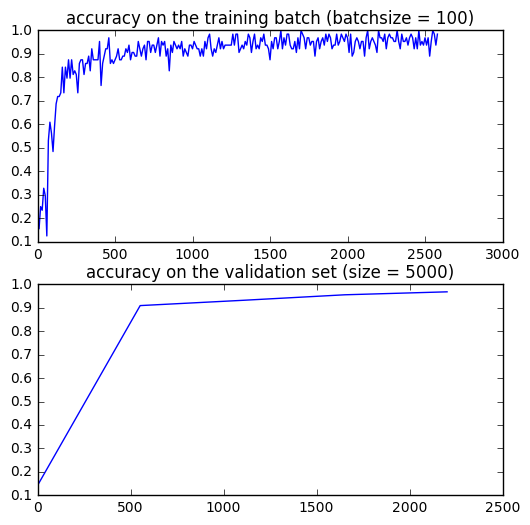

In [72]:
f = plt.figure(figsize=(6,6))
plt.subplot(2,1,1)
plt.plot(train_step,ACC_train)
plt.title('accuracy on the training batch (batchsize = 100)')
plt.subplot(2,1,2)
plt.plot(test_steps,ACC_test)
plt.title('accuracy on the validation set (size = 5000)')


# The following are the test code
ideally, we should have written all the helpper function, inference, training and eval in a .py file, and imported as a library at the beginning of training.ipynb and test.ipynb, such that we can have a separate notebook for testing using the same set of functions

In [79]:
tf.reset_default_graph()
# Input placeholders
with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, [None, 784], name='x-input')
    y_= tf.placeholder(tf.float32, [None, 10], name='y-input')
    

with tf.name_scope('input_reshape'):
    # reshape the image to 4-dim tensor before putting through a conv_layer
    x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
    tf.image_summary('input', x_image, 10)

logits = inference(x_image)
accuracy = eval(logits,y_)
saver = tf.train.Saver()

sess = tf.Session()
with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "summary/run2/model_3_.ckpt")
    print("Model restored.")
    xs, ys = data.test.images,data.test.labels
    acc= sess.run(accuracy,feed_dict={x: xs, y_: ys})
    print acc




sess.close()

Model restored.
0.9684
